# Imagenet Pipeline Profiling Analysis

### Prerequisites

None. Exemplary logs are loaded by default. Experiments were run on:

* Storage: CEPH SSDs
* CPU: Intel Xeon E5-2630 v3 8x@2.4GHz
* Image: ubuntu-18.04-lts/Openstack
* Memory: 20GB DDR4

All plots that are not saved with the `save_fig` function were not used in the paper, but may provide a close-up look on specific values.

### Meta information

* "first" preprocessing step of listing the files was removed (check `imagenet_demo.py`) because it did not affect performance in our tests. This should be reintroduced when simulating distributed training, e.g., federated learning, where getting the file locations can actually affect performance

* Dataset size: `146.899991342 GB` (`imagenet/ILSVRC/Data/CLS-LOC/train> du -hb .` / 1000 / 1000)
* Amount of `.JPEG` files: `1281167` (`imagenet/ILSVRC/Data/CLS-LOC/train> find . -name "*.JPEG" | wc -l`)
* Avg. filesize: `0.11466107957978935 MB`
* Avg. resolution (Imagenet paper): `400x350`
* Sample sizes (rounded to second decimal):
    * `   0500:        57.33 MB` 
    * `   1000:       114.66 MB`
    * `   2000:       229.32 MB`
    * `   4000:       458.64 MB`
    * `   8000:       917.29 MB`
    * `1281167: 146899.99 MB` 

## General Dataset Information

In [6]:
full_dataset_imagecount = 1281167
for sample_size in [500, 1000, 2000, 4000, 8000]:
    print(f"{sample_size} of total: {round(sample_size / full_dataset_imagecount * 100, 2)}%")

500 of total: 0.04%
1000 of total: 0.08%
2000 of total: 0.16%
4000 of total: 0.31%
8000 of total: 0.62%


In [7]:
%load_ext autoreload
%autoreload 2
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import ticker
from typing import List
# adding previous directory for easier use of library
import sys
sys.path.append('../')
sys.path.append('../..')

from notebookhelper import show_values_on_bars, save_figure

from presto.analysis import StrategyAnalysis \
                       , strat_analysis_from_csv

pd.set_option('display.max_rows', 200)
plotting_context = "paper"
plotting_palette = "deep"
font_scale = 1.4
sns.set(font_scale=font_scale, context=plotting_context, palette=plotting_palette)
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
local_fig_dir = "imagenet-pipeline"

def save_fig(name, file_type='pdf'):
    save_figure(name, local_fig_dir=local_fig_dir, file_type=file_type)

home_path = "../../logs/imagenet"
path_to_cum_df = f"{home_path}/imagenet_2021-03-04-16:42:59_cum-df_samples-500-1000-2000-4000-8000-1281167_threads-1-2-4-8.csv"
path_to_cum_dstat_df = f"{home_path}/imagenet_2021-03-04-16:42:59_cum-dstat-df_samples-500-1000-2000-4000-8000-1281167_threads-1-2-4-8.csv"
sampling_tag = ""

analysis = strat_analysis_from_csv(path_to_cum_dstat_df = path_to_cum_dstat_df
                                   , path_to_cum_df = path_to_cum_df)
cum_dstat_df = analysis.to_cum_dstat_df()
cum_df       = analysis.to_cum_df()
summary      = analysis.summary()
strategies   = summary.strategy.unique()
strategies_renamed = ["unprocessed", "read-images", "decoded", "resized", "full"] #"pixel-centered"]
summary

,preprocessing_time_s,storage_consumption_mb,throughput_sps,per_epoch_processing_time_s,strategy,threads,sample_count
0,0.000000,0.000000e+00,92.033096,5.459509,0-fully-online,1,500
1,0.000000,0.000000e+00,105.108925,9.530154,0-fully-online,1,1000
2,0.000000,0.000000e+00,112.207741,17.830374,0-fully-online,1,2000
3,0.000000,0.000000e+00,112.182739,35.927586,0-fully-online,1,4000
4,0.000000,0.000000e+00,125.625854,63.686440,0-fully-online,1,8000
5,NaN,NaN,NaN,NaN,0-fully-online,1,1281167
6,0.000000,0.000000e+00,184.807343,2.711145,0-fully-online,2,500
7,0.000000,0.000000e+00,193.035889,5.190859,0-fully-online,2,1000
8,0.000000,0.000000e+00,208.920746,9.591372,0-fully-online,2,2000
9,0.000000,0.000000e+00,207.146927,19.346472,0-fully-online,2,4000


In [9]:
cum_df.head(5)

,offline_processing_and_save_time_s,shard_count,thread_count,shard_cum_size_MB,sample_count,online_processing_time_s,throughput_sps,runs_count,runs_total,ueid,split_name,creation_timestamp
0,0.0,1,1,0.0,500,6.027188,82.957420,0,5,3c31e3,0-fully-online,2021-03-04-16:42:59
1,0.0,1,1,0.0,500,5.528242,90.444672,1,5,3c31e3,0-fully-online,2021-03-04-16:42:59
2,0.0,1,1,0.0,500,4.880363,102.451393,2,5,3c31e3,0-fully-online,2021-03-04-16:42:59
3,0.0,1,1,0.0,500,5.600437,89.278740,3,5,3c31e3,0-fully-online,2021-03-04-16:42:59
4,0.0,1,1,0.0,500,5.261317,95.033249,4,5,3c31e3,0-fully-online,2021-03-04-16:42:59


In [12]:
cum_dstat_df.head(5)

,rel_time_s,disk_read_mbs,disk_write_mbs,net_read_mbs,net_write_mbs,run,sample_count,shard_count,thread_count,ueid,split_name,creation_timestamp
0,0.0,0.018322,0.012588,0.000000,0.000000,1,500,1,1,3c31e3,0-fully-online,2021-03-04-16:42:59
1,1.0,0.065536,0.000000,9.723328,0.089339,1,500,1,1,3c31e3,0-fully-online,2021-03-04-16:42:59
2,2.0,0.000000,0.000000,11.738417,0.104409,1,500,1,1,3c31e3,0-fully-online,2021-03-04-16:42:59
3,3.0,0.000000,0.000000,14.078763,0.117296,1,500,1,1,3c31e3,0-fully-online,2021-03-04-16:42:59
4,4.0,0.000000,0.000000,13.965981,0.107670,1,500,1,1,3c31e3,0-fully-online,2021-03-04-16:42:59


## 0. Experiment Information

### 0.1 Experiment Count
We define an experiment as profiling a materialization strategy (e.g., `0-fully-online`) with a certain sample count (e.g, `500`).

We replicated **every** experiment **5** times, that means we should have `5 * <mat-strategies> * <thread_count>` experiments for each sample size. The only exception is the full dataset preprocessing, which is ran with `thread_count = 8`

Unfortunately the `ueid`s are based on the way the experiments were ran (in the python loop vs. bash loop), so we only count the rows, as each row in the `cum_df` dataframe is a single experiment.

In [ ]:
experiment_count_dict = {
    "sample_count": []
  , "sample_experiment_count": []
  , "thread_count": []
  , "thread_experiment_count": []
  , "norm_thread_experiment_count": []
}

def get_experiment_count(df):
    '''Short helper'''
    return len(df.index)

def add_to_dict(sample_count, sample_experiment_count
              , thread_count, thread_experiment_count, norm_thread_experiment_count):
    '''Short helper'''
    experiment_count_dict["sample_count"] += [sample_count]
    experiment_count_dict["sample_experiment_count"] += [sample_experiment_count]
    experiment_count_dict["thread_count"] += [thread_count]
    experiment_count_dict["thread_experiment_count"] += [thread_experiment_count]
    experiment_count_dict["norm_thread_experiment_count"] += [norm_thread_experiment_count]

for sample_count in cum_df["sample_count"].unique():
    sample_experiment_count = get_experiment_count(cum_df.query(f'sample_count=={sample_count}'))
    for thread_count in cum_df.query(f'sample_count=={sample_count}')['thread_count'].unique():
        thread_experiment_count = get_experiment_count(cum_df.query(f'sample_count=={sample_count} and thread_count=={thread_count}'))
        norm_thread_experiment_count = thread_experiment_count / len(strategies)
        add_to_dict(sample_count, sample_experiment_count,
                    thread_count, thread_experiment_count, norm_thread_experiment_count)
        
experiment_count_df = pd.DataFrame.from_dict(experiment_count_dict)
experiment_count_df

# 1. Storage Consumption Analysis

## 1.1 Uncompressed dataset storage consumption compared the different strategies

In [ ]:
sample_size_mb_dict = {
    "500": 58.42
  , "1000": 116.84
  , "2000": 233.68
  , "4000": 467.35
  , "8000": 934.71
  , f"{full_dataset_imagecount}": 146899.991342
}

storage_consumption_comparison = {
    "storage_consumption": []
  , "sample_count": []
  , "strategy": []
}

def add_to_dict(size, sample_count, label):
    '''Short helper'''
    storage_consumption_comparison["storage_consumption"] += [size]
    storage_consumption_comparison["sample_count"] += [sample_count]
    storage_consumption_comparison["strategy"] += [label]
    
for sample_count in cum_df.sample_count.unique():
    for i, strategy in enumerate(strategies):
        shard_sizes_mb = cum_df.query(f"split_name=='{strategy}' and sample_count=={sample_count}")["shard_cum_size_MB"].to_numpy()
        for size_mb in shard_sizes_mb:
            if i == 0: # i.e., unprocessed
                size_mb = sample_size_mb_dict[str(sample_count)]
            add_to_dict(size = size_mb
                      , sample_count = sample_count
                      , label = strategies[i])

storage_df = pd.DataFrame(storage_consumption_comparison)

from matplotlib.lines import Line2D

throughput_color = "#515151"
marker = 'o'
linestyle = ":"

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.set(font_scale=1.4)

## throughput plot
plot2 = sns.pointplot(x="split_name", y="throughput_sps",
                    data=cum_df.query(f"sample_count=={np.max(cum_df.sample_count.unique())}"),
                    ax=ax2, scale=0.75, color=throughput_color, linestyles=linestyle, ci=0.95, marker='o')

plot2.set(ylabel="Throughput in Samples per Second")
plot2.set_xticklabels(
    strategies_renamed
  , rotation=20
)
ax2.grid(False)
legend_elements = [Line2D([0], [0], marker=marker, markersize=10, color=throughput_color, lw=3.05, label='Throughput', linestyle=linestyle)]
ax2.legend(handles=legend_elements, loc="upper left", prop={'size': 14})
plot2.set(ylim=(0, 2300))          

plot = sns.barplot(
        x="strategy",
        y="storage_consumption",
        data=storage_df.query(f"sample_count=={np.max(cum_df.sample_count.unique())}"),
        ax=ax1
    )
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
show_values_on_bars(plot, h_v="v", space=160000, rotation=15, additional_x_space=[0,0,0,0,-0.15])
plot.set(ylabel="Storage Consumption in MB", xlabel="Strategy")
plot.set(ylim=(0, 1650000))

# FuncFormatter can be used as a decorator
@ticker.FuncFormatter
def major_formatter(value, pos):
    return re.sub(r'(?<!^)(?=(\d{3})+$)', r',', str(value)[0:-2])

plot.yaxis.set_major_formatter(major_formatter)
#save_fig("storage-consumption")

# 2. Preprocessing Time Anaylsis

## 2.1 Preprocessing time plots

In [ ]:
plot = sns.barplot(
    x="split_name",
    y="online_processing_time_s",
    hue="thread_count",
    data=cum_df.query(f"sample_count==8000")
)
plot.set_title(f"Per Epoch Preprocessing Time\n with Sample Size 8000 {sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Time in Seconds")
plot.set(ylim=(0, 100))

In [ ]:
plot = sns.barplot(
    x="split_name",
    y="offline_processing_and_save_time_s",
    hue="thread_count",
    data=cum_df.query(f"sample_count==8000")
)
plot.set_title(f"Preprocessing \"Once\" Time\n with Sample Size 8000 {sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Time in Seconds")
plot.set(ylim=(0, 140))

## 2.2 Unmarshalling cost for last data representation

In [ ]:
test_df = cum_df.copy(deep=True)
test_df["normalized_online_processing_time_s"] = test_df["online_processing_time_s"] / test_df["sample_count"]

plot = sns.barplot(
    x="sample_count",
    y="normalized_online_processing_time_s",
    hue="thread_count",
    data=test_df.query(f"split_name=='{strategies[-1]}'")
)
plot.set_title(f"Fully Preprocessed Unmarshalling Time\n(normalized by sample size){sampling_tag}")
plot.set(xlabel="Sample Count", ylabel="Time in Seconds")
#plot.set(ylim=(0,1.4))

# 3. Throughput Analysis

## 3.1 Throughput (sample_count = 8000)

In [ ]:
plot = sns.barplot(
    x="split_name",
    y="throughput_sps",
    hue="thread_count",
    data=cum_df.query(f"sample_count=={full_dataset_imagecount}")
)
plot.set_title(f"Throughput per Strategy {sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Samples per Second")
plot.set(ylim=(0, 2700))

additional_space = [-180, -105, -150, 0, 0] \
                 + [-50, 0, 0, 0, 0] \
                 + [60, 0, -80, 0, 0] \
                 + [0, 0, 0, 0, 100]
show_values_on_bars(plot, space=300, additional_space=additional_space)

## 3.2 Parallelization capabilities (sample_count = 8000)

In [ ]:
cum_8000_df = cum_df.query("sample_count==8000")

par_capability = {
      "threads": []
    , "strategy": []
    , "speedup": []
}

def add_capability(threads, strategy, speedup):
    par_capability["threads"] += [threads]
    par_capability["strategy"] += [strategy]
    par_capability["speedup"] += [speedup]

for strategy in strategies:
    for thread_count in cum_df.thread_count.unique():
        throughputs = cum_8000_df.query(f"thread_count=={thread_count} and split_name=='{strategy}'")["throughput_sps"].to_numpy()
        for throughput in throughputs:
            avg_step_t1_throughput = cum_8000_df.query(f"thread_count=={1} and split_name=='{strategy}'")["throughput_sps"].mean()
            # not using percentages here as I feel its more intuitive, benchmarking crimes is still followed from my understanding
            #if avg_step_t1_throughput < throughput:
            #    rel_increase_factor =  throughput / avg_step_t1_throughput - 1
            #    add_capability(thread_count, strategy, np.round(rel_increase_factor, 2))
            #else:
            #    rel_decrease_factor = 1 - throughput / avg_step_t1_throughput
            #    add_capability(thread_count, strategy, -np.round(rel_decrease_factor, 2))
            ## now using speedup instead of increase/decrease factor
            speedup = throughput / avg_step_t1_throughput
            add_capability(thread_count, strategy, speedup)


            capability_df = pd.DataFrame(par_capability)
capability_df

In [ ]:
sns.set(font_scale=1.3)
plot = sns.barplot(
    x="strategy",
    y="speedup",
    hue="threads",
    data=capability_df
)

plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)

#plot.set_title(f"Speedup for Each Strategy Compared to\n Average Single Threaded Throughput\n with a Sample Size 8000")
plot.set(xlabel="Strategy", ylabel="Speedup")
plot.set(ylim=(0, 7))
plot.legend(title="Threads", ncol=1,labelspacing=0.05)
save_fig("speedup")

## 4. Extrapolation Capabilities

In [ ]:
# calculate the per sample processing time for both offline and online processing
cum_df["per_sample_online_processing_time_s"] = cum_df["online_processing_time_s"] / cum_df["sample_count"]
cum_df["per_sample_offline_processing_and_save_time_s"] = cum_df["offline_processing_and_save_time_s"] / cum_df["sample_count"]
# calculate the total processing time for each sample count
cum_df["total_processing_time_s"] = cum_df["online_processing_time_s"] + cum_df["offline_processing_and_save_time_s"]
# extrapolate based on the full count of images
cum_df["full_dataset_online_processing_time_s"] = cum_df["per_sample_online_processing_time_s"] * full_dataset_imagecount
cum_df["full_dataset_offline_processing_and_save_time_s"] = cum_df["per_sample_offline_processing_and_save_time_s"] * full_dataset_imagecount
cum_df["full_dataset_offline_processing_and_save_time_m"] = cum_df["full_dataset_offline_processing_and_save_time_s"] / 60

# sum the offline and online time for the full dataset processing time (converted to hours)
cum_df["full_dataset_processing_time_s"] = cum_df["full_dataset_online_processing_time_s"] + cum_df["full_dataset_offline_processing_and_save_time_s"]
cum_df["full_dataset_processing_time_m"] = cum_df["full_dataset_processing_time_s"] / 60 


cum_df_mod = cum_df.copy(deep=True)
cum_df_mod.loc[cum_df_mod.sample_count == 1281167, 'sample_count'] = '1.3M (full)'
order_dict = { 500: 10, 1000: 11, 2000: 12, 4000: 13, 8000: 14, '1.3M (full)': 15}
strategy_order_dict = dict(list(enumerate(strategies)))
strategy_order_dict = dict({(y, x) for x, y in strategy_order_dict.items()})
order_dict.update(strategy_order_dict)
cum_df_mod = cum_df_mod.sort_values(by=['split_name', 'sample_count'], key=lambda x: x.map(order_dict))

cum_df_mod

In [ ]:
plot = sns.barplot(
    x="split_name",
    y="throughput_sps",
    hue="sample_count",
    data=cum_df_mod.query(f"thread_count==8")
)
#plot.set_title(f"Throughput per Strategy with 8 Threads\n{sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Throughput in Samples per Second")
plot.set(ylim=(0, 3000))
plot.legend(title="Sample Count", ncol=1,labelspacing=0.05)
save_fig("throughput")
#additional_space = [-180, -105, -150, 0, 0] \
#                 + [-50, 0, 0, 0, 0] \
#                 + [60, 0, -80, 0, 0] \
#                 + [0, 0, 0, 0, 100]
#show_values_on_bars(plot, space=500)# additional_space=additional_space)

In [17]:
# First calculation for the introduction - unprocessed vs resized
unprocessed='0-fully-online'
resized='4-resize-image'
full='5-center-pixel-values'
unprocessed_mean_throughput = cum_df.query(f"sample_count=={full_dataset_imagecount} and thread_count==8 and split_name=='{unprocessed}'")["throughput_sps"].mean()
resized_mean_throughput = cum_df.query(f"sample_count=={full_dataset_imagecount} and thread_count==8 and split_name=='{resized}'")["throughput_sps"].mean()
full_mean_throughput = cum_df.query(f"sample_count=={full_dataset_imagecount} and thread_count==8 and split_name=='{full}'")["throughput_sps"].mean()
print(f"Unprocessed strategy throughput (8 threads):  {np.round(unprocessed_mean_throughput,0)} sps")
print(f"Resized     strategy throughput (8 threads): {np.round(resized_mean_throughput,0)} sps")
print(f"Full        strategy throughput (8 threads):  {np.round(full_mean_throughput,0)} sps")

Unprocessed strategy throughput (8 threads):  588.0 sps
Resized     strategy throughput (8 threads): 2123.0 sps
Full        strategy throughput (8 threads):  798.0 sps


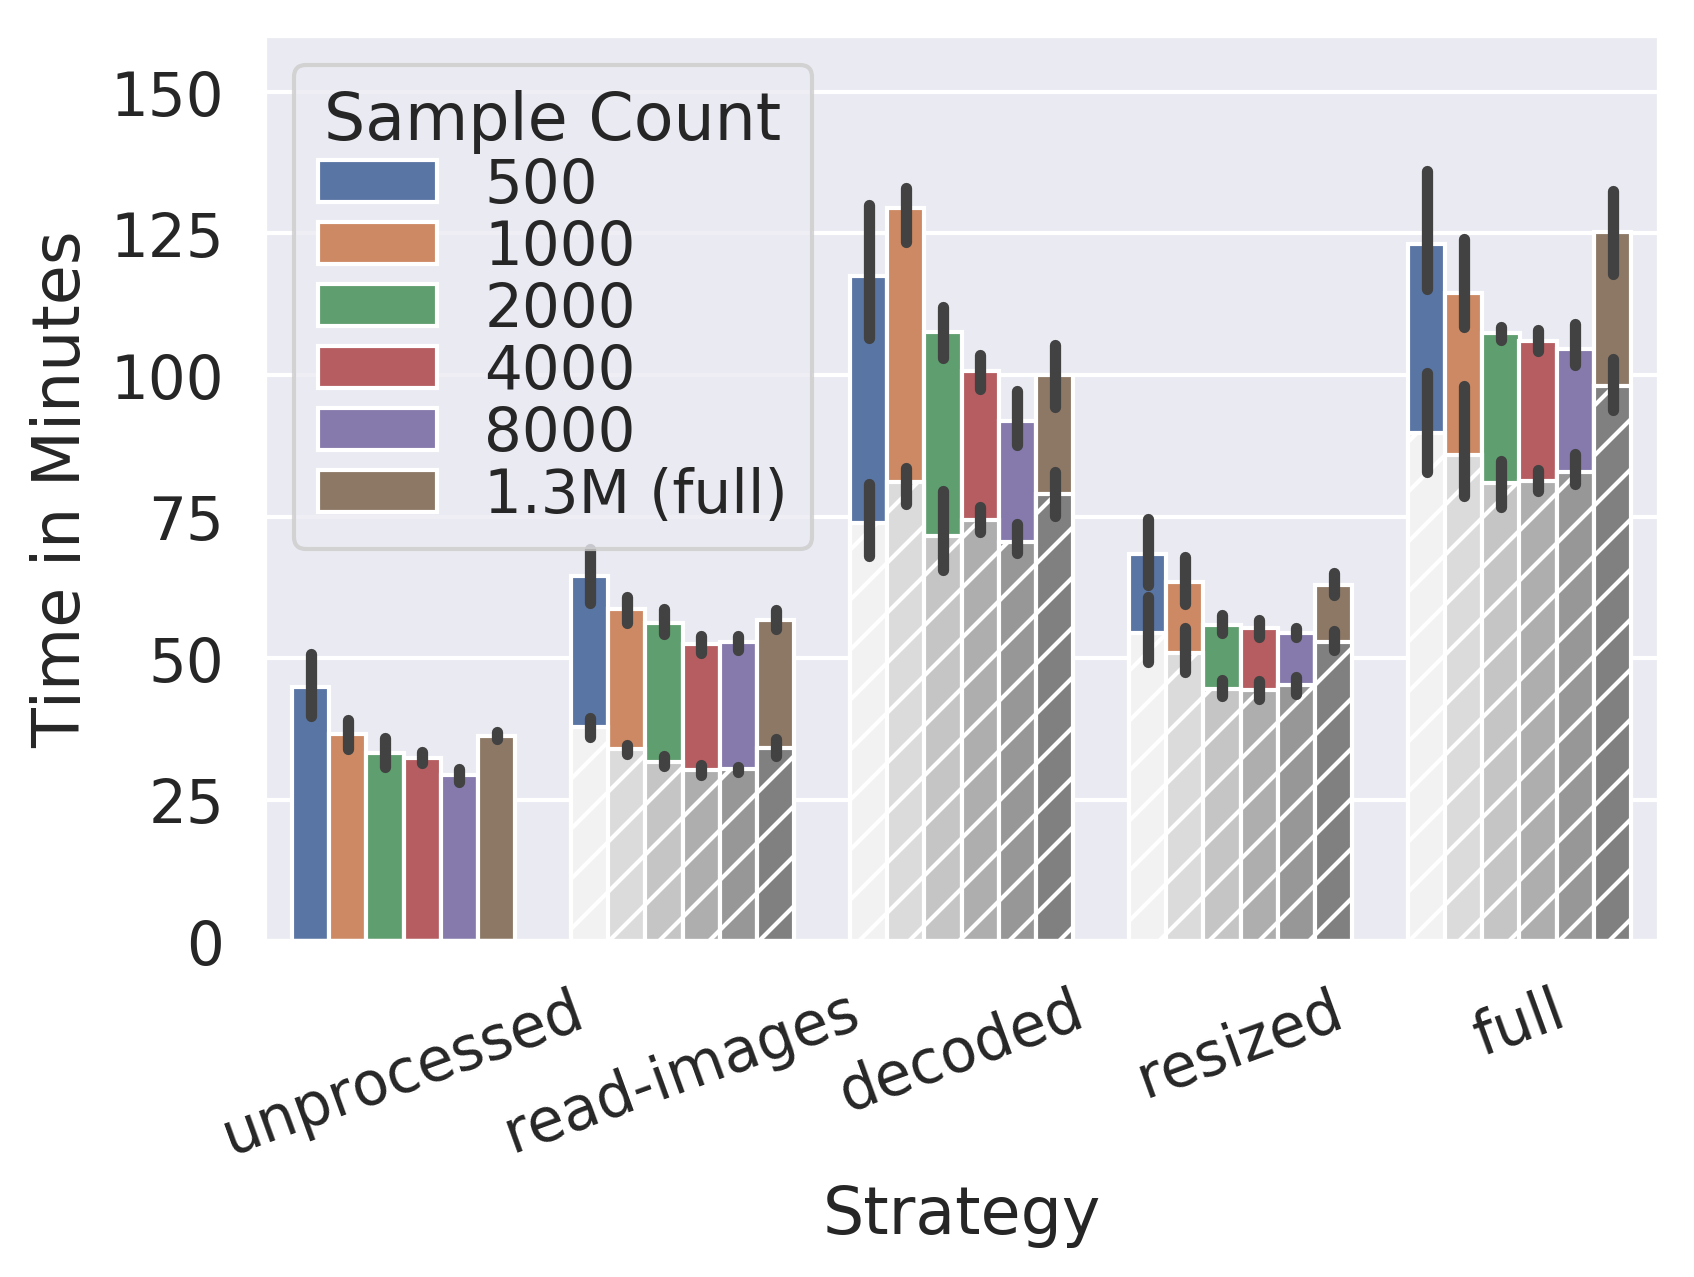

In [18]:
plot = sns.barplot(
    x="split_name",
    y="full_dataset_processing_time_m",
    hue="sample_count",
    data=cum_df_mod.query(f"thread_count==8")
)
plot = sns.barplot(
    x="split_name",
    y="full_dataset_offline_processing_and_save_time_m",
    hue="sample_count",
    data=cum_df_mod.query(f"thread_count==8"),
    color="grey"
)

sample_counts = len([500, 1000, 2000, 4000, 8000, '13M (full)']) 
bars_to_skip = sample_counts * len(strategies)
hatches = ['//'] * bars_to_skip
for i,bar in enumerate(plot.patches[bars_to_skip:]):
    bar.set_hatch(hatches[i])

#plot.set_title(f"Per Epoch Per Sample Processing Time\n for Each Strategy with 8 Threads{sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Time in Minutes")
plot.set(ylim=(0, 160))

handles, labels = plot.get_legend_handles_labels()
plot.legend(handles=handles[:sample_counts], title="Sample Count", loc="upper left", ncol=1, labelspacing=0.05, columnspacing=0.3)
save_fig("full-processing-time")

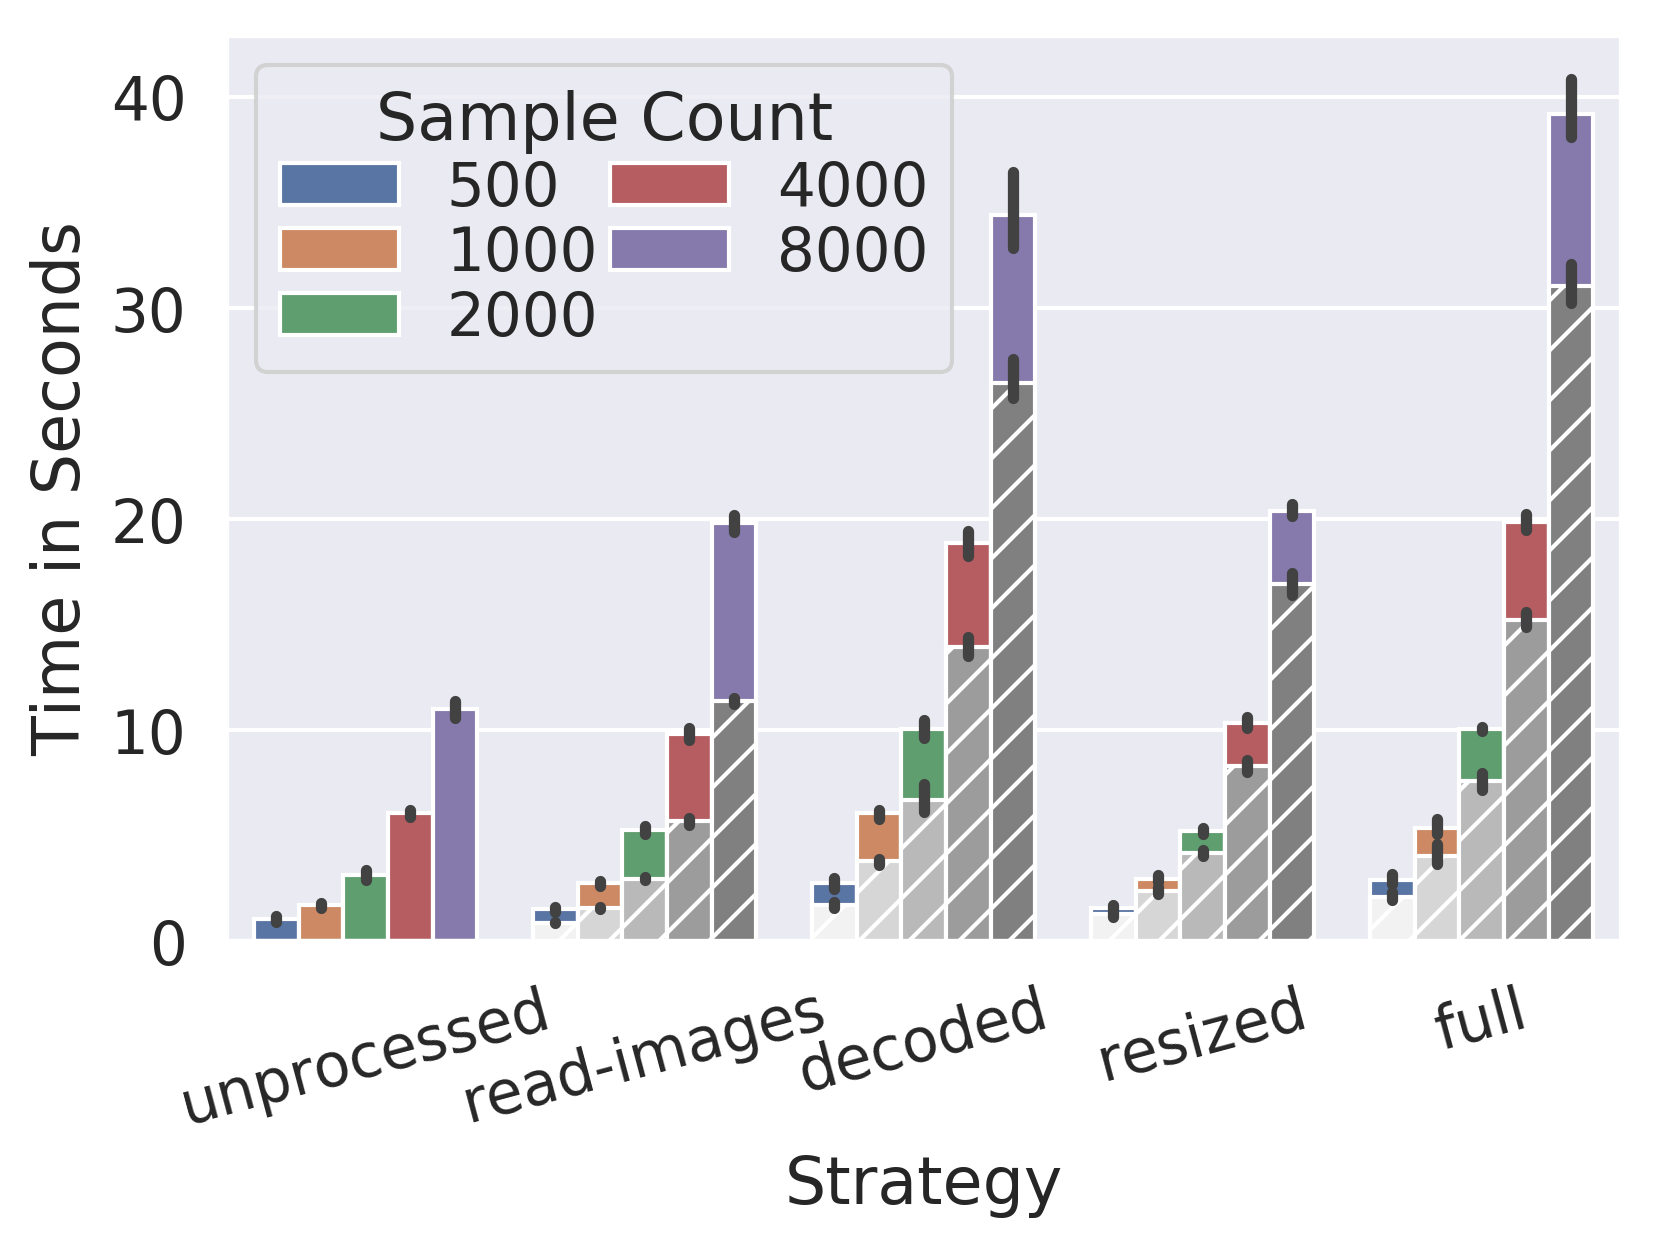

In [19]:
cum_df_preprocessing_time_comparison = cum_df_mod.query(f"thread_count==8 and sample_count!='1.3M (full)'")
sns.set(font_scale=1.3)

plot = sns.barplot(
    x="split_name",
    y="total_processing_time_s",
    hue="sample_count",
    data=cum_df_preprocessing_time_comparison
)
plot = sns.barplot(
    x="split_name",
    y="offline_processing_and_save_time_s",
    hue="sample_count",
    data=cum_df_preprocessing_time_comparison,
    color="grey"
)
sample_counts = len([500, 1000, 2000, 4000, 8000])
bars_to_skip = sample_counts * len(strategies)
hatches = ['//'] * bars_to_skip
for i,bar in enumerate(plot.patches[bars_to_skip:]):
    bar.set_hatch(hatches[i])

#plot.set_title(f"Per Epoch Per Sample Processing Time\n for Each Strategy with 8 Threads{sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=15
)
plot.set(xlabel="Strategy", ylabel="Time in Seconds")
#plot.set(ylim=(0, 27))

handles, labels = plot.get_legend_handles_labels()
plot.legend(handles=handles[:sample_counts], title="Sample Count", loc="upper left", ncol=2, labelspacing=0.10, columnspacing=0.2)
save_fig("processing-time-per-sample-count")

# Warning - Creating the plots based on `dstat` logs can take several hours

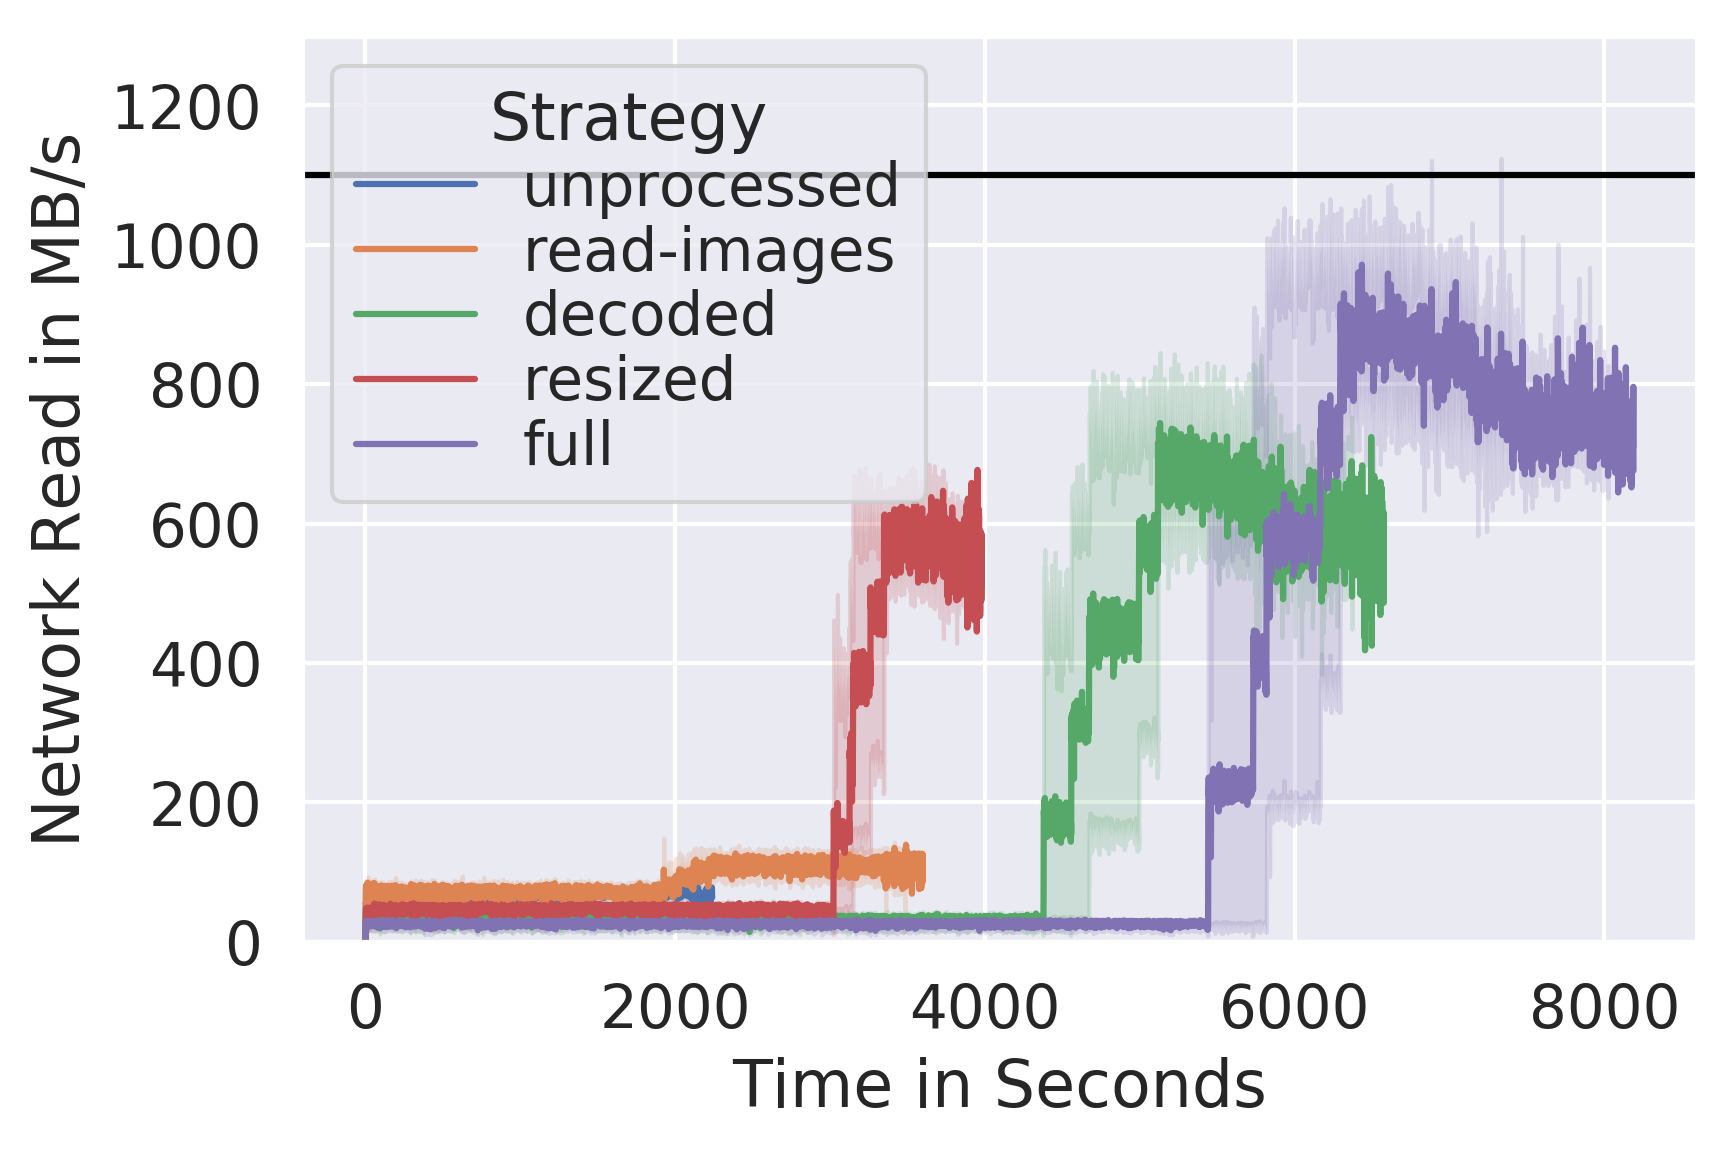

In [20]:
sns.set(font_scale=1.3)
test_df = cum_dstat_df.query(f"sample_count=={full_dataset_imagecount}").copy(deep=True)
test_df["sample_count"] = test_df.sample_count.astype('category')
test_df["split_name"] = test_df.split_name.astype('category')
test_df["thread_count"] = test_df.thread_count.astype('category')
plot = sns.lineplot(
    x="rel_time_s",
    y="net_read_mbs",
    hue="split_name",
    data=test_df.query("thread_count==8"),
    ci=95
)
plot.set(xlabel="Time in Seconds", ylabel="Network Read in MB/s")
plot.set(ylim=(0, 1300))
plot.axhline(1100, color="black")
plot.legend(strategies_renamed, title="Strategy", loc="upper left", ncol=1,labelspacing=0.10)
save_fig("network-read-speed-t8-full", file_type="png")

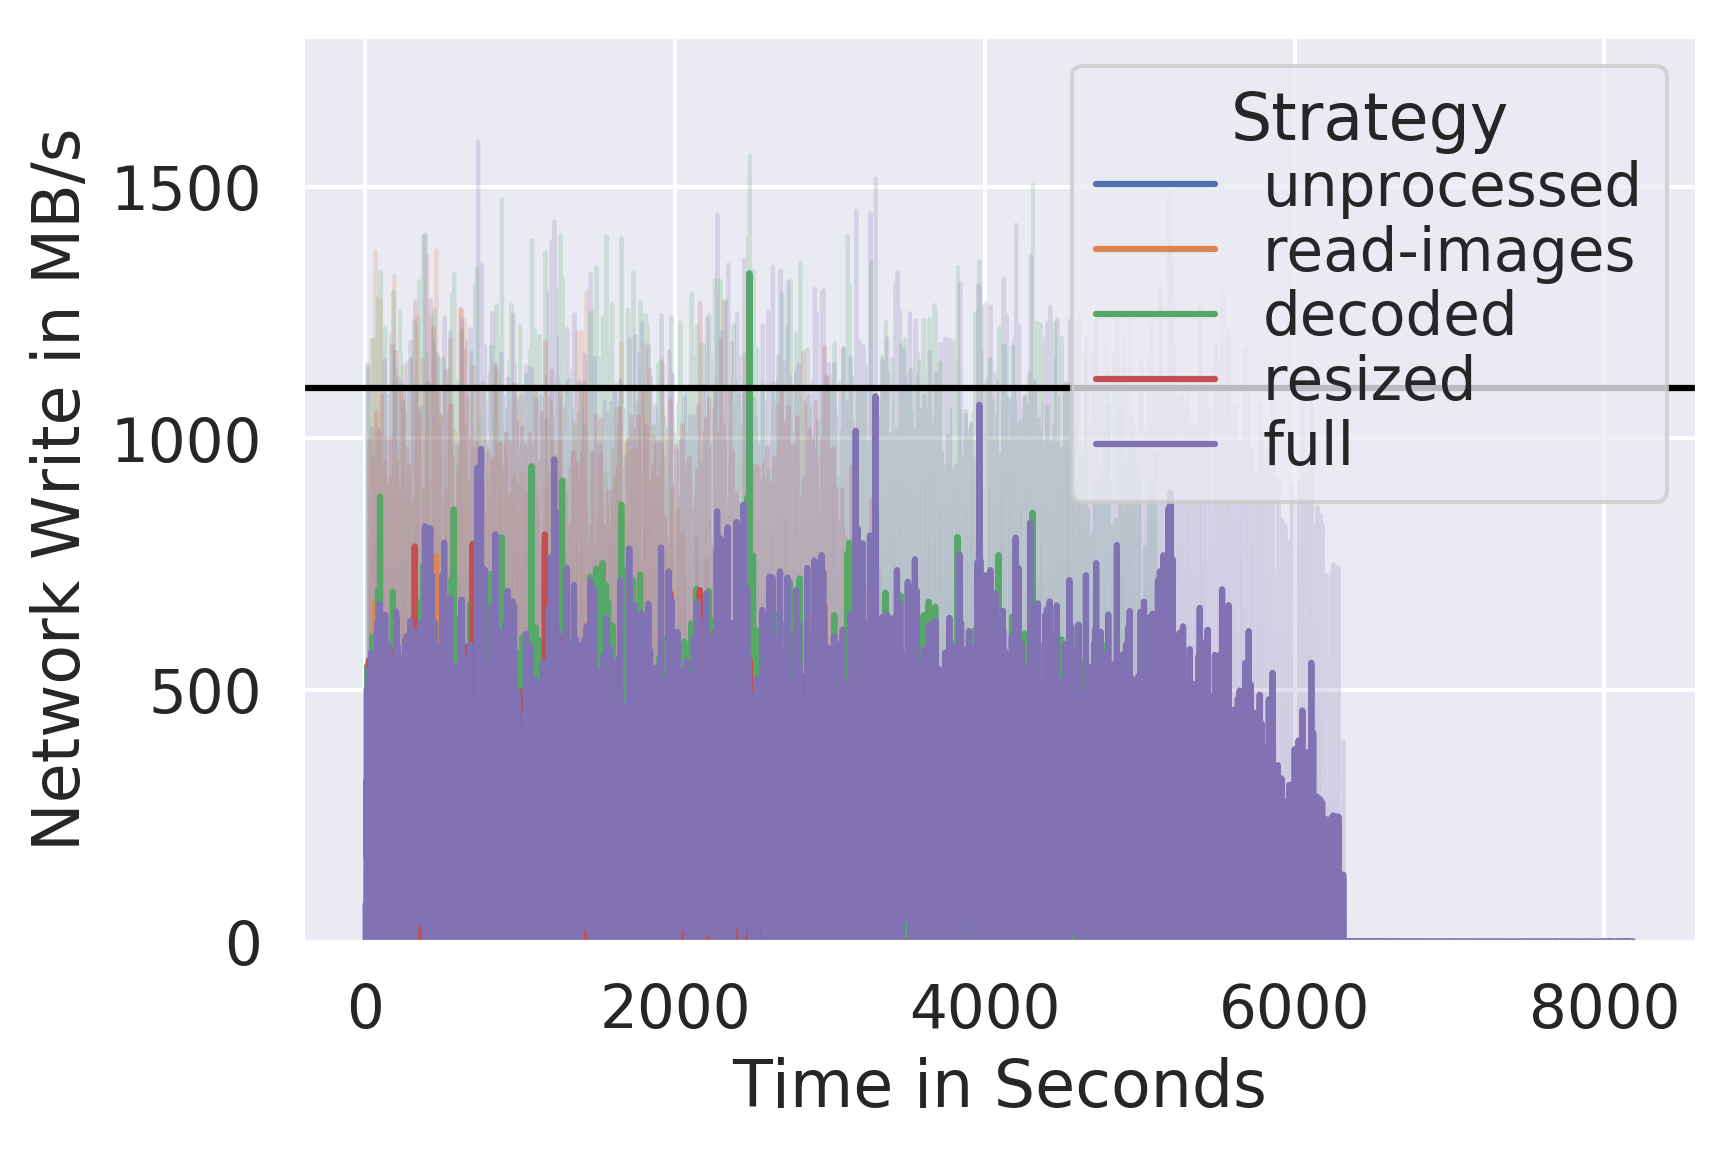

In [21]:
sns.set(font_scale=1.3)
test_df = cum_dstat_df.query(f"sample_count=={full_dataset_imagecount}").copy(deep=True)
test_df["sample_count"] = test_df.sample_count.astype('category')
test_df["split_name"] = test_df.split_name.astype('category')
test_df["thread_count"] = test_df.thread_count.astype('category')
plot = sns.lineplot(
    x="rel_time_s",
    y="net_write_mbs",
    hue="split_name",
    data=test_df.query("thread_count==8"),
    ci=95
)
plot.set(xlabel="Time in Seconds", ylabel="Network Write in MB/s")
plot.set(ylim=(0, 1800))
plot.axhline(1100, color="black")
plot.legend(strategies_renamed, title="Strategy", loc="upper right", ncol=1,labelspacing=0.10)
save_fig("network-write-speed-t8-full", file_type="png")

In [15]:
run = 0
threads = 8
sample_count = full_dataset_imagecount
unprocessed = '0-fully-online'
concatenated = '2-read-image'

test_dstat_df = cum_dstat_df.query(f"thread_count=={threads} and \
                                     sample_count=={sample_count}")
unprocessed_dstat_df = test_dstat_df.query(f"split_name=='{unprocessed}'")

print("---------------------------------------")
print("-- Unprocessed Network Read in MB/s --")
print(unprocessed_dstat_df.describe()["net_read_mbs"])

# because we have multiple runs and they dont stop at the same second, we take the maximum run and cut from there
# to average the network read speed
max_offline_processing_time_s = cum_df.query(f"split_name=='{concatenated}' and \
                     runs_count=={run} and \
                     thread_count=={threads} and \
                     sample_count=={sample_count}")["offline_processing_and_save_time_s"].max()

concatenated_dstat_df = test_dstat_df.query(f"split_name=='{concatenated}' and \
                                              rel_time_s>={max_offline_processing_time_s}")
print("---------------------------------------")
print("-- Concatenated Network Read in MB/s --")
print(concatenated_dstat_df.describe()["net_read_mbs"])

---------------------------------------
-- Unprocessed Network Read in MB/s --
count    10897.000000
mean        68.308426
std          7.852918
min          0.000000
25%         64.696411
50%         69.285545
75%         73.318787
max         91.242821
Name: net_read_mbs, dtype: float64
---------------------------------------
-- Concatenated Network Read in MB/s --
count    6006.000000
mean      108.587624
std        15.370499
min         0.000060
25%       100.810844
50%       109.401161
75%       117.819798
max       149.807938
Name: net_read_mbs, dtype: float64


In [14]:
run = 0
threads = 8
sample_count = 1281167
decoded = '3-decode-image'

# because we have multiple runs and they dont stop at the same second, we take the maximum run and cut from there
# to average the network read speed
max_offline_processing_time_s = cum_df.query(f"split_name=='{decoded}' and \
                     thread_count=={threads} and \
                     sample_count=={sample_count}")["offline_processing_and_save_time_s"].max()
print(max_offline_processing_time_s)
decoded_dstat_df = cum_dstat_df.query(f"split_name=='{decoded}' and \
                                        thread_count=={threads} and \
                                        rel_time_s>={max_offline_processing_time_s}")

print("---------------------------------------")
print("-- Decoded Network Read in MB/s --")
print(decoded_dstat_df.describe()["net_read_mbs"])

5109.6904
---------------------------------------
-- Decoded Network Read in MB/s --
count    4500.000000
mean      643.674194
std        87.689583
min         0.000000
25%       582.314636
50%       632.879456
75%       705.141434
max       930.072571
Name: net_read_mbs, dtype: float64
